In [107]:
# Import Libraries

import pandas as pd
import numpy as np
from textblob import TextBlob
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import nltk
import re
import string

# py -3.9 -m pip install wordcloud-1.8.1-cp39-cp39-win_amd64.whl 
from wordcloud import WordCloud
from PIL import Image
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer


In [54]:
twitter_data = pd.read_csv("./twitter_tweets_final_1.csv")
twitter_data.head()


,UserName,Handle,Timestamp,Text,Emojis,Comments,Likes,Retweets
0,Hosky Token ($HOSKY),@hoskytoken,2021-11-18T01:26:13.000Z,I present you the King of all Idiots! \r\n \r\...,NaN,30,34,212
1,Hosky Token ($HOSKY),@hoskytoken,2021-11-18T01:14:44.000Z,"$HOSKY Token, forcing others to innovate as we...",NaN,18,17,203
2,CONR₳D,@conraddit,2021-11-18T00:52:55.000Z,We are the first generation to vote on a block...,NaN,14,26,294
3,Hosky Token ($HOSKY),@hoskytoken,2021-11-17T23:37:38.000Z,That’s a lot of soiled wallets. \r\n \r\n #car...,NaN,21,27,183
4,Healthy Pockets,@healthy_pockets,2021-11-17T23:19:16.000Z,ÚLTIMO\r\n \r\n #Cardano llega a los cajeros e...,NaN,33,144,743


In [55]:
# parameters
positive = 0
negative = 0
neutral = 0
polarity = 0

neutral_list = []
negative_list = []
positive_list = []

# tweet list from the twitter data
tweets_text = twitter_data["Text"]

for tweet in tweets_text:
    analysis = TextBlob(tweet)
    polarity += analysis.sentiment.polarity

    # Give a sentiment intensity score to sentences.
    score = SentimentIntensityAnalyzer().polarity_scores(tweet)
    neg = score['neg']
    neu = score['neu']
    pos = score['pos']
    comp = score['compound']

    if neg > pos:
        negative_list.append(tweet)
        negative += 1
    elif pos > neg:
        positive_list.append(tweet)
        positive += 1
    elif pos == neg:
        neutral_list.append(tweet)
        neutral += 1

positive_percent = 100 * float(positive) / float(len(tweets_text))
negative_percent = 100 * float(negative) / float(len(tweets_text))
neutral_percent = 100 * float(neutral) / float(len(tweets_text))

positive_percent = format(positive_percent, '.1f')
negative_percent = format(negative_percent, '.1f')
neutral_percent = format(neutral_percent, '.1f')


In [56]:
print(positive , "(" + positive_percent + "%) of tweets include positive sentiment")
print(negative , "(" + negative_percent + "%) of tweets include negative sentiment")
print(neutral , "(" + neutral_percent + "%) of tweets include neutral sentiment")

4781 (61.9%) of tweets include positive sentiment
869 (11.3%) of tweets include negative sentiment
2070 (26.8%) of tweets include neutral sentiment


In [57]:
# pie chart showing the sentiment analysis result
labels = ['Positive [' + str(positive_percent) +'%]', 'Neutral [' + str(neutral_percent) + '%]', 'Negative [' + str(negative_percent) + ' %]']
values = [positive, neutral, negative]

fig = go.Figure(data=[go.Pie(labels=labels, values=values, textinfo='label')])
fig.update_layout(template="plotly_dark", title="Result of Sentiment Analysis", legend=dict(
    y=0.99,
    x=0.01
), margin=dict(t=50, b=10, l=100, r=100))
fig.show()


In [58]:
# cleaning twitter text (punctuations, links, etc)
# creating new dataFrame and adding new features

tweets_db = pd.DataFrame(tweets_text)
tweets_db.columns = ["originalTweets"]

# removing punctuations
eng_punct = string.punctuation
def clean_punctuations(text):
    trans = str.maketrans('', '', eng_punct)
    return text.translate(trans)

# removing URLs
def cleaning_URLs(text):
    return re.sub('((www.[^s]+)|(https?://[^s]+))', ' ', text)

# removing escape characters
def clean_escape_char(text):
    return re.sub("\r\n", " ", text)

tweets_db["cleanedTweets"] = tweets_db.originalTweets.apply(lambda x: clean_punctuations(x))
tweets_db["cleanedTweets"] = tweets_db.cleanedTweets.apply(lambda x: cleaning_URLs(x))
tweets_db["cleanedTweets"] = tweets_db.cleanedTweets.apply(lambda x: clean_escape_char(x))

# changing  the text to lowerCase
tweets_db["cleanedTweets"] = tweets_db.cleanedTweets.str.lower()
tweets_db.head()


,originalTweets,cleanedTweets
0,I present you the King of all Idiots! \r\n \r\...,i present you the king of all idiots carda...
1,"$HOSKY Token, forcing others to innovate as we...",hosky token forcing others to innovate as we h...
2,We are the first generation to vote on a block...,we are the first generation to vote on a block...
3,That’s a lot of soiled wallets. \r\n \r\n #car...,that’s a lot of soiled wallets cardano ada...
4,ÚLTIMO\r\n \r\n #Cardano llega a los cajeros e...,último cardano llega a los cajeros españole...


In [59]:
# Calculating polarity and subjectivity
tweets_db[['‘polarity', 'subjectivity']] = tweets_db['cleanedTweets'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))

#Calculating Negative, Positive, Neutral and Compound values of cleanedTweets
for index, row in tweets_db['cleanedTweets'].iteritems():
    score = SentimentIntensityAnalyzer().polarity_scores(row)
    neg = score['neg']
    neu = score['neu']
    pos = score['pos']
    comp = score['compound']

    if neg > pos:
        tweets_db.loc[index, 'sentiment'] = "negative"
    elif pos > neg:
        tweets_db.loc[index, 'sentiment'] = "positive"
    else:
        tweets_db.loc[index, 'sentiment'] = "neutral"

    tweets_db.loc[index, 'neg'] = neg
    tweets_db.loc[index, 'neu'] = neu
    tweets_db.loc[index, 'pos'] = pos
    tweets_db.loc[index, 'compound'] = comp

tweets_db.head()

,originalTweets,cleanedTweets,‘polarity,subjectivity,sentiment,neg,neu,pos,compound
0,I present you the King of all Idiots! \r\n \r\...,i present you the king of all idiots carda...,-0.40,0.400000,neutral,0.000,1.000,0.000,0.00
1,"$HOSKY Token, forcing others to innovate as we...",hosky token forcing others to innovate as we h...,0.00,0.000000,positive,0.098,0.759,0.143,0.25
2,We are the first generation to vote on a block...,we are the first generation to vote on a block...,0.25,0.333333,neutral,0.000,1.000,0.000,0.00
3,That’s a lot of soiled wallets. \r\n \r\n #car...,that’s a lot of soiled wallets cardano ada...,0.00,0.000000,neutral,0.000,1.000,0.000,0.00
4,ÚLTIMO\r\n \r\n #Cardano llega a los cajeros e...,último cardano llega a los cajeros españole...,0.00,0.000000,positive,0.000,0.924,0.076,0.34


In [60]:
#Creating new data frames for all sentiments (positive, negative and neutral)

tweets_db_pos = tweets_db[tweets_db["sentiment"] == "positive"]
tweets_db_neg = tweets_db[tweets_db["sentiment"] == "negative"]
tweets_db_neu = tweets_db[tweets_db["sentiment"] == "neutral"]

In [61]:
positive = tweets_db_pos.shape[0]
negative = tweets_db_neg.shape[0]
neutral = tweets_db_neu.shape[0]

positive_percent = 100 * float(positive) / float(len(tweets_text))
negative_percent = 100 * float(negative) / float(len(tweets_text))
neutral_percent = 100 * float(neutral) / float(len(tweets_text))
polarity_percent = 100 * float(polarity) / float(len(tweets_text))

positive_percent = format(positive_percent, '.1f')
negative_percent = format(negative_percent, '.1f')
neutral_percent = format(neutral_percent, '.1f')

print(positive, "(" + positive_percent + "%) of tweets include positive sentiment")
print(negative, "(" + negative_percent + "%) of tweets include negative sentiment")
print(neutral, "(" + neutral_percent + "%) of tweets include neutral sentiment")

4801 (62.2%) of tweets include positive sentiment
895 (11.6%) of tweets include negative sentiment
2024 (26.2%) of tweets include neutral sentiment


In [62]:
# pie chart showing the sentiment analysis result of cleanedTweets
labels = ['Positive [' + str(positive_percent) + '%]', 'Neutral [' + str(
    neutral_percent) + '%]', 'Negative [' + str(negative_percent) + ' %]']
values = [positive, neutral, negative]

fig = go.Figure(data=[go.Pie(labels=labels, values=values, textinfo='label', hole=0.2)])
fig.update_layout(template="plotly_dark", title="Result of Sentiment Analysis of cleanedTweets", legend=dict(
    y=0.99,
    x=0.01
), margin=dict(t=50, b=10, l=100, r=100))
fig.show()


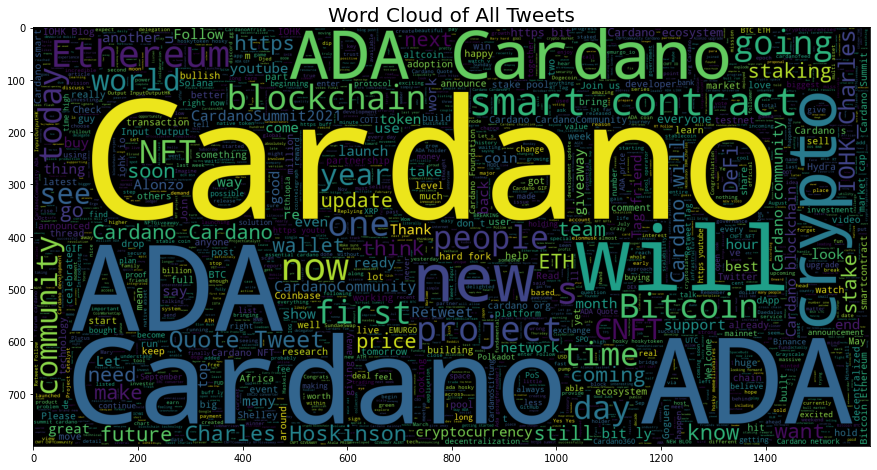

In [11]:
#Creating wordcloud for all tweets
tweets_all = tweets_text

plt.figure(figsize=(15,15))
word_cloud = WordCloud(max_words=3000, width=1600,
                       height=800).generate(" ".join(tweets_all))
word_cloud.to_file("./WordCloud/allTweetsWordCloud.png")
plt.title("Word Cloud of All Tweets", fontdict={'fontsize': 20})
plt.imshow(word_cloud)


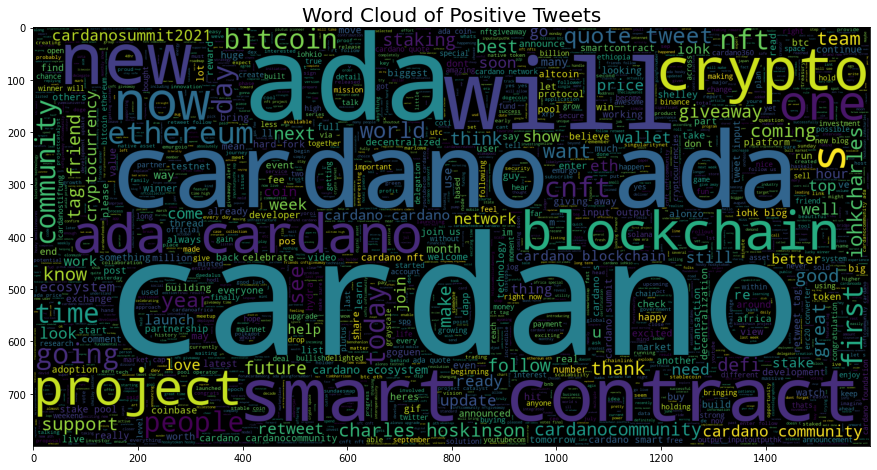

In [12]:
#Creating wordcloud for positive tweets
tweets_pos = tweets_db_pos["cleanedTweets"]

plt.figure(figsize=(15, 15))
word_cloud = WordCloud(max_words=3000, width=1600,
                       height=800).generate(" ".join(tweets_pos))
word_cloud.to_file("./WordCloud/positiveTweetsWordCloud.png")
plt.title("Word Cloud of Positive Tweets", fontdict={'fontsize': 20})
plt.imshow(word_cloud)


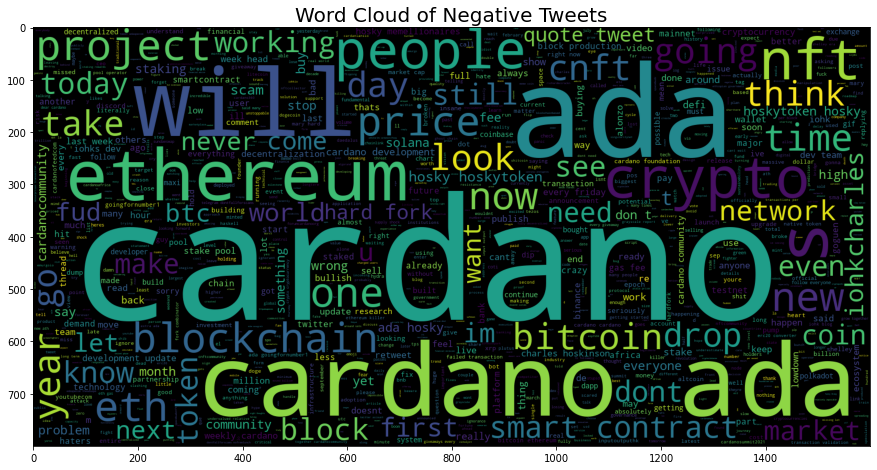

In [13]:
#Creating wordcloud for negative tweets
tweets_neg = tweets_db_neg["cleanedTweets"]

plt.figure(figsize=(15, 15))
word_cloud = WordCloud(max_words=3000, width=1600,
                       height=800).generate(" ".join(tweets_neg))
word_cloud.to_file("./WordCloud/negativeTweetsWordCloud.png")
plt.title("Word Cloud of Negative Tweets", fontdict={'fontsize': 20})
plt.imshow(word_cloud)


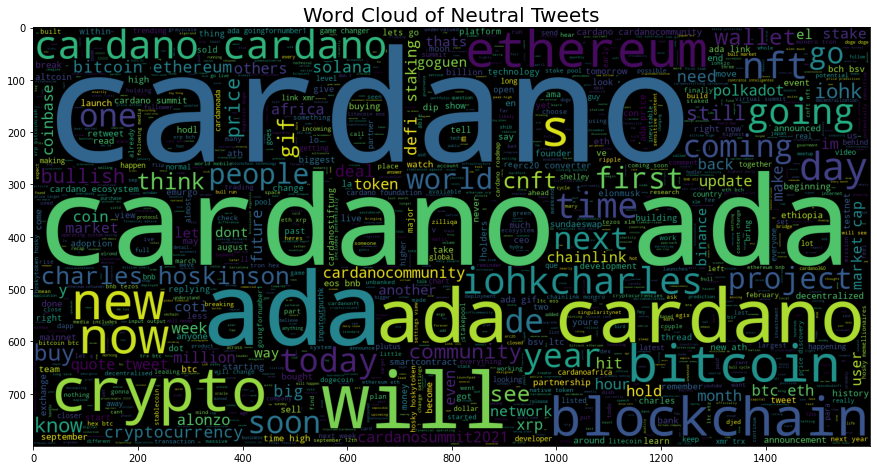

In [14]:
#Creating wordcloud for neutral tweets
tweets_neu = tweets_db_neu["cleanedTweets"]

plt.figure(figsize=(15, 15))
word_cloud = WordCloud(max_words=3000, width=1600,
                       height=800).generate(" ".join(tweets_neu))
word_cloud.to_file("./WordCloud/neutralTweetsWordCloud.png")
plt.title("Word Cloud of Neutral Tweets", fontdict={'fontsize': 20})
plt.imshow(word_cloud)


In [63]:
# Calculating tweet’s length and word count
# to analyze the density of words and characters used in tweets based on different sentiment.

tweets_db['text_len'] = tweets_db['cleanedTweets'].astype(str).apply(len)
tweets_db['text_word_count'] = tweets_db['cleanedTweets'].apply(lambda x: len(str(x).split()))


In [64]:
round(pd.DataFrame(tweets_db.groupby("sentiment").text_len.mean()), 2)

,text_len
sentiment,
negative,187.06
neutral,105.79
positive,216.83


In [65]:
round(pd.DataFrame(tweets_db.groupby("sentiment").text_word_count.mean()), 2)

,text_word_count
sentiment,
negative,31.25
neutral,16.70
positive,34.68


In [102]:
# Appliyng tokenization
# tokenizing involves splitting sentences and words from the body of the text.
def tokenization(text):
    return (word_tokenize(text))

# Removing stopwords
# In natural language processing, useless words(data), are referred to as stop words.
stopword = nltk.corpus.stopwords.words('english')
def remove_stopwords(text):
    text = [word for word in text if word not in stopword]
    return text

# Applying Stemmer
# It provides the root of words. So you can eliminate words that come from the same root.
ps = nltk.PorterStemmer()
def stemming(text):
    text = [ps.stem(word) for word in text]
    return text

# Applying Lemmatizer
# the process of grouping together the different inflected forms of a word so they can be analyzed as a single item.
lm = nltk.WordNetLemmatizer()
def lemmatizing(data):
    text = [lm.lemmatize(word) for word in data]
    return text

tweets_db['tokenized'] = tweets_db['cleanedTweets'].apply(
    lambda x: tokenization(x))
tweets_db['nonstop'] = tweets_db['tokenized'].apply(
    lambda x: remove_stopwords(x))
tweets_db['stemmed'] = tweets_db['nonstop'].apply(
    lambda x: stemming(x))
tweets_db['lemmatized'] = tweets_db['stemmed'].apply(
    lambda x: lemmatizing(x))

tweets_db.head()

,originalTweets,cleanedTweets,‘polarity,subjectivity,sentiment,neg,neu,pos,compound,text_len,text_word_count,tokenized,nonstop,stemmed,lemmatized
0,I present you the King of all Idiots! \r\n \r\...,i present you the king of all idiots carda...,-0.40,0.400000,neutral,0.000,1.000,0.000,0.00,238,31,"[i, present, you, the, king, of, all, idiots, ...","[present, king, idiots, cardano, ada, ada, hos...","[present, king, idiot, cardano, ada, ada, hosk...","[present, king, idiot, cardano, ada, ada, hosk..."
1,"$HOSKY Token, forcing others to innovate as we...",hosky token forcing others to innovate as we h...,0.00,0.000000,positive,0.098,0.759,0.143,0.25,119,19,"[hosky, token, forcing, others, to, innovate, ...","[hosky, token, forcing, others, innovate, plan...","[hoski, token, forc, other, innov, plan, carda...","[hoski, token, forc, other, innov, plan, carda..."
2,We are the first generation to vote on a block...,we are the first generation to vote on a block...,0.25,0.333333,neutral,0.000,1.000,0.000,0.00,135,23,"[we, are, the, first, generation, to, vote, on...","[first, generation, vote, blockchain, sundaesw...","[first, gener, vote, blockchain, sundaeswap, r...","[first, gener, vote, blockchain, sundaeswap, r..."
3,That’s a lot of soiled wallets. \r\n \r\n #car...,that’s a lot of soiled wallets cardano ada...,0.00,0.000000,neutral,0.000,1.000,0.000,0.00,88,13,"[that, ’, s, a, lot, of, soiled, wallets, card...","[’, lot, soiled, wallets, cardano, ada, ada, h...","[’, lot, soil, wallet, cardano, ada, ada, hosk...","[’, lot, soil, wallet, cardano, ada, ada, hosk..."
4,ÚLTIMO\r\n \r\n #Cardano llega a los cajeros e...,último cardano llega a los cajeros españole...,0.00,0.000000,positive,0.000,0.924,0.076,0.34,193,31,"[último, cardano, llega, a, los, cajeros, espa...","[último, cardano, llega, los, cajeros, español...","[último, cardano, llega, lo, cajero, español, ...","[último, cardano, llega, lo, cajero, español, ..."


In [81]:
analysis = TextBlob(" ".join(tweets_db.lemmatized[0]))
polarity = analysis.sentiment.polarity
subjectivity = analysis.sentiment.subjectivity


In [108]:
def tweet_sentiment_analysis(tweet):
    # removing punctuations
    eng_punct = string.punctuation
    def clean_punctuations(text):
        trans = str.maketrans('', '', eng_punct)
        return text.translate(trans)

    # removing URLs
    def cleaning_URLs(text):
        return re.sub('((www.[^s]+)|(https?://[^s]+))', ' ', text)

    # removing escape characters
    def clean_escape_char(text):
        return re.sub("\r\n", " ", text)

    # Appliyng tokenization
    # tokenizing involves splitting sentences and words from the body of the text.
    def tokenization(text):
        return (word_tokenize(text))

    # Removing stopwords
    # In natural language processing, useless words(data), are referred to as stop words.
    stopword = nltk.corpus.stopwords.words('english')
    def remove_stopwords(text):
        text = [word for word in text if word not in stopword]
        return text

    # Applying Stemmer
    # It provides the root of words. So you can eliminate words that come from the same root.
    ps = nltk.PorterStemmer()
    def stemming(text):
        text = [ps.stem(word) for word in text]
        return text

    # Applying Lemmatizer
    # the process of grouping together the different inflected forms of a word so they can be analyzed as a single item.
    lm = nltk.WordNetLemmatizer()
    def lemmatizing(data):
        text = [lm.lemmatize(word) for word in data]
        text = " ".join(text)
        return text


    tweets_db = pd.DataFrame([[tweet]])
    tweets_db.columns = ["originalTweets"]
    tweets_db["cleanedTweets"] = tweets_db.originalTweets.apply(
        lambda x: clean_punctuations(x))
    tweets_db["cleanedTweets"] = tweets_db.cleanedTweets.apply(
        lambda x: cleaning_URLs(x))
    tweets_db["cleanedTweets"] = tweets_db.cleanedTweets.apply(
        lambda x: clean_escape_char(x))
    tweets_db['cleanedTweets'] = tweets_db.cleanedTweets.apply(
        lambda x: tokenization(x))
    tweets_db['cleanedTweets'] = tweets_db.cleanedTweets.apply(
        lambda x: remove_stopwords(x))
    tweets_db['cleanedTweets'] = tweets_db.cleanedTweets.apply(
        lambda x: stemming(x))
    tweets_db['cleanedTweets'] = tweets_db.cleanedTweets.apply(
        lambda x: lemmatizing(x))

    # changing  the text to lowerCase
    tweets_db["cleanedTweets"] = tweets_db.cleanedTweets.str.lower()

    tweets_db.head()

    analysis = TextBlob(tweets_db.cleanedTweets[0])
    polarity = analysis.sentiment.polarity
    subjectivity = analysis.sentiment.subjectivity

    # Give a sentiment intensity score to sentences.
    score = SentimentIntensityAnalyzer().polarity_scores(
        tweets_db.cleanedTweets[0])
    neg = score['neg']
    neu = score['neu']
    pos = score['pos']
    comp = score['compound']

    if neg > pos:
        tweets_db['sentiment'] = "negative"
    elif pos > neg:
        tweets_db['sentiment'] = "positive"
    else:
        tweets_db['sentiment'] = "neutral"

    tweets_db['polarity'] = polarity
    tweets_db['subjectivity'] = subjectivity
    tweets_db['neg'] = neg
    tweets_db['neu'] = neu
    tweets_db['pos'] = pos
    tweets_db['compound'] = comp
    tweets_db['text_len'] = tweets_db['cleanedTweets'].astype(str).apply(len)
    tweets_db['text_word_count'] = tweets_db['cleanedTweets'].apply(
        lambda x: len(str(x).split()))

    return tweets_db


In [109]:
tweet_sentiment_analysis("It is best to hold cardano!!")

,originalTweets,cleanedTweets,sentiment,polarity,subjectivity,neg,neu,pos,compound,text_len,text_word_count
0,It is best to hold cardano!!,it best hold cardano,positive,1.0,0.3,0.0,0.417,0.583,0.6369,20,4
